# Author: Kumar Awanish,
    Content: Implementation of multiclass classification on complete data(Approach C)
        Technology used: Python3, Pandas, Spark, Tsne

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorAssembler, IndexToString
from pyspark.sql.functions import *
from pyspark.context import SparkContext
from pyspark.serializers import MarshalSerializer
import time
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import os
from pyspark.ml.regression import RandomForestRegressor

# Setting Spark enviroment 

In [2]:
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
SparkContext.setSystemProperty('spark.executor.memory', '6g')
#SparkContext.setSystemProperty('spark.driver.memory', '10g')
sc = SparkContext('local','example')  # if using locally
sql_sc = SQLContext(sc)

Data loading and change type to float

In [3]:
def data_loading(dataset):
    """
    This function will load dataset using Spark cluster.
    :param dataset: dataset to load and process
    :return: a Spark dataframe
    """
    dataset=sql_sc.read.format('csv').options(header='true', inferSchema='true').load(dataset)
    # #changing column header name
    dataset = dataset.select(*[col(s).alias('Label') if s == ' Label' else s for s in dataset.columns])
    #to change datatype
    dataset=dataset.drop('External IP')
    dataset = dataset.filter(dataset.Label.isNotNull())
    dataset=dataset.filter(dataset.Label!=' Label')#filter Label from label
    print(dataset.groupBy('Label').count().collect())
    return dataset

In [4]:
def data_preprocessing(dataset):
    """
    This function is for preprocessing of datasets.
    :param dataset: a spark dataframe
    :return finalRegressionData: a spark dataframe after preprocessing 
    """
    featureList=[' Flow Duration', ' Fwd IAT Min', ' Bwd IAT Mean', ' Fwd IAT Mean','Init_Win_bytes_forward',' Subflow Fwd Bytes','Total Length of Fwd Packets',
      ' ACK Flag Count', ' Active Min', 'Active Mean',' Flow IAT Std','Init_Win_bytes_forward','Fwd PSH Flags',' SYN Flag Count',
      'Fwd Packets/s',' Bwd Packet Length Std','Total Length of Fwd Packets','Init_Win_bytes_forward',' Init_Win_bytes_backward','Total Length of Fwd Packets',
      'Total Length of Fwd Packets','Active Mean','Total Length of Fwd Packets',' Fwd Packet Length Mean',' Average Packet Size','Init_Win_bytes_forward', ' Bwd Packets/s', ' PSH Flag Count', ' Flow IAT Min', ' Fwd IAT Min', ' Flow IAT Mean']

    uniqueFeature=list(set(featureList))
    uniqueFeature.append('Label')
    #data set for regression
    dataForRegression=dataset.select([c for c in dataset.columns if c in uniqueFeature])
    #from pyspark.ml.feature import StringIndexer
    indexer = StringIndexer(inputCol="Label", outputCol="categoryIndex")
    indexed = indexer.fit(dataForRegression).transform(dataForRegression)
    print("StringIndexer will store labels in output column metadata\n")

    converter = IndexToString(inputCol="categoryIndex", outputCol="originalCategory")
    converted = converter.transform(indexed)

    print("Transformed indexed column '%s' back to original string column '%s' using "
          "labels in metadata" % (converter.getInputCol(), converter.getOutputCol()))
    converted.select("Label", "categoryIndex", "originalCategory").show(5)
    #check encoding and decoding
    print(converted.groupBy('categoryIndex','originalCategory').count().collect())
    dataRegression=indexed.drop('Label')
    #to change datatype
    finalRegressionData=dataRegression.select(*(col(c).cast("float").alias(c) for c in dataRegression.columns))
    #finalRegressionData.cache()
    finalRegressionData = finalRegressionData.filter(finalRegressionData.categoryIndex.isNotNull())
    finalRegressionData = finalRegressionData.na.fill(0.0)
    print(finalRegressionData.groupBy('categoryIndex').count().collect())
    return finalRegressionData

In [5]:
def vectorAssembler(finalRegressionData):
    """
    This function is for creating feature indexer, which will be helpful in running RF model on PySpark Api.
    :param finalRegressionData: preprocessed spark dataframe
    :return finalRegressionData: spark dataframe with feature indexer column added to it
    """
    stages = [] # stages in our Pipeline
    assemblerInputs=finalRegressionData.columns[0:-1]
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    #assembler.transform(final_data)
    assembler.transform(finalRegressionData.na.drop())
    stages += [assembler]
    cols = finalRegressionData.columns
    # Create a Pipeline.
    pipeline = Pipeline(stages=stages)
    # Run the feature transformations.
    #  - fit() computes feature statistics as needed.
    #  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(finalRegressionData)
    finalRegressionData = pipelineModel.transform(finalRegressionData)
    # Keep relevant columns
    selectedcols = ["features"] + cols
    finalRegressionData = finalRegressionData.select(selectedcols)
    return finalRegressionData

In [11]:
def results_For_RegrAttacks(finalRegressionDataFromAssembler):
    """
    This method output model accuracy and its results
    :param finalRegressionDataFromAssembler:  preprocessed spark dataframe
    :return trainingData, testData: test and train data
    """
    # Split the data into training and test sets (30% held out for testing)
    (trainingData, testData) = finalRegressionDataFromAssembler.randomSplit([0.85, 0.15])
    model=RandomForestRegressor(featuresCol="features",labelCol="categoryIndex",maxDepth=10,numTrees=100)
    #,numTrees=100,maxDepth=20
    time_start = time.time()
    rf=model.fit(trainingData)
    print ('Training time for RF Regressor: {} seconds'.format(time.time()-time_start))
    rf.save('mdoelTrainedApproachC')
    predictions=rf.transform(testData)
    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="categoryIndex", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    outputrf=np.array(predictions.select('prediction').collect())
    input_array=np.array(testData.select('categoryIndex').collect())
    print("Precision Score for RF model=%g"%(precision_score(input_array, outputrf.round(), average='macro')))
    print("Recall Score for RF model=%g"%(recall_score(input_array, outputrf.round(), average='macro') )) 
    print("F1 ->macro Score for RF model=%g"%(f1_score(input_array, outputrf.round(), average='macro')))
    print("Benign vs Attack result")
    print(classification_report(input_array, outputrf.round()))
    return trainingData, testData, rf,outputrf

Visualisation using Tsne 

In [13]:
import time
from sklearn.manifold import TSNE
def tsneTrain(testData):
    datavisualisation=testData.toPandas()
    datavisualisation.drop(['features', ' SYN Flag Count', ' PSH Flag Count',' ACK Flag Count','Fwd PSH Flags'],axis=1,inplace=True)
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=50)
    tsne_resultsRf = tsne.fit_transform(datavisualisation[:80000])
    print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_resultsRf
%matplotlib inline
def plot(tsne_resultsRfPred,labelss):
    target_ids = range(0,15)
    #target_ids = range(0,2)
    font_size = 10
    from matplotlib import pyplot as plt
    #plt.figure(figsize=(6, 5))
    plt.figure(figsize=(10,10))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple','dimgray','rosybrown','firebrick','maroon','khaki','indigo'
    #colors = 'r', 'g'
    for i, c, label in zip(target_ids, colors, [_ for _ in target_ids]):
        plt.scatter(tsne_resultsRfPred[labelss==i, 0], tsne_resultsRfPred[labelss==i, 1], c=c, label=label,s=1.5)
    plt.title("Predcited Data Distribution on complete data by applying RF regressor ", fontsize=font_size,loc="center")
    plt.xlabel("Dimension 1", fontsize=font_size)
    plt.ylabel("Dimension 2", fontsize=font_size)
    plt.legend(loc=1,fontsize =font_size,bbox_to_anchor=(1.05, 1,), borderaxespad=-3.3)
    plt.show()

# Steps to train and run Approach C

In [9]:
#Step1: load data
dataset=data_loading("./CSVs/final.csv")

#Step2: preprocess data
finalRegressionData=data_preprocessing(dataset)

#Step3: vector assembler
finalRegressionDataFromAssembler=vectorAssembler(finalRegressionData)

[Row(Label='BENIGN', count=2359289), Row(Label='SSH-Patator', count=5897), Row(Label='Web Attack � Brute Force', count=1507), Row(Label='Infiltration', count=36), Row(Label='DoS slowloris', count=5796), Row(Label='Web Attack � Sql Injection', count=21), Row(Label='DoS Hulk', count=231073), Row(Label='PortScan', count=158930), Row(Label='DoS Slowhttptest', count=5499), Row(Label='Bot', count=1966), Row(Label='DoS GoldenEye', count=10293), Row(Label='DDoS', count=41835), Row(Label='FTP-Patator', count=7938), Row(Label='Heartbleed', count=11), Row(Label='Web Attack � XSS', count=652)]
StringIndexer will store labels in output column metadata

Transformed indexed column 'categoryIndex' back to original string column 'originalCategory' using labels in metadata
+------+-------------+----------------+
| Label|categoryIndex|originalCategory|
+------+-------------+----------------+
|BENIGN|          0.0|          BENIGN|
|BENIGN|          0.0|          BENIGN|
|BENIGN|          0.0|          BE

In [14]:
#Step4: model evaluation and results
trainingData, testData,rf,outputrf=results_For_RegrAttacks(finalRegressionDataFromAssembler)

Training time for RF Regressor: 4286.414102554321 seconds
Root Mean Squared Error (RMSE) on test data = 0.38425


/home/awanish/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awanish/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision Score for RF model=0.468155
Recall Score for RF model=0.453023
F1 ->macro Score for RF model=0.431664
Benign vs Attack result
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98    353960
        1.0       0.66      0.99      0.79     34558
        2.0       0.97      1.00      0.98     23858
        3.0       0.76      0.21      0.33      6306
        4.0       0.72      0.79      0.75      1544
        5.0       0.70      0.98      0.82      1214
        6.0       0.00      0.00      0.00       859
        7.0       0.54      0.81      0.65       841
        8.0       1.00      0.29      0.45       819
        9.0       0.00      0.00      0.00       286
       10.0       0.68      0.76      0.72       237
       11.0       0.00      0.00      0.00       107
       12.0       0.00      0.00      0.00         5
       13.0       0.00      0.00      0.00         2
       14.0       0.00      0.00      0.00         4

avg / total   

/home/awanish/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Visualisation using Tsne on test data for true and predicted labels

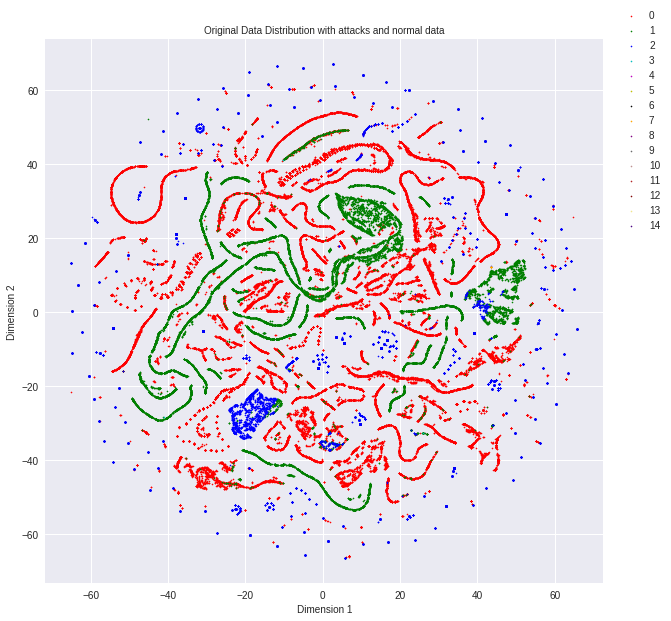

In [82]:
#Train tsne 
tsne_resultsRf=tsneTrain(testData)

#flatted to covert from(x,1) to (x,)
predctedLable=outputrf.round().flatten()
#plot tsne for predictedLabel
plot(tsne_resultsRf,predctedLable[:80000])

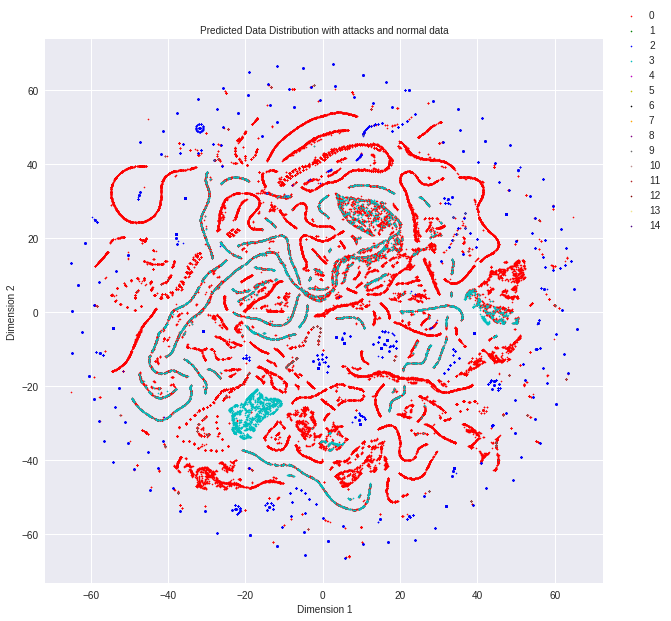

In [84]:
truelabel=input_array.flatten()
#plot tsne for predictedLabel
plot(tsne_resultsRf,truelabel[:80000])